<a href="https://colab.research.google.com/github/patrick-nanys/text-summarization/blob/main/glove_text_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep learning homework - Milestone 2
#####Topic: NLP - text summarization
#####Authors: Patrick Nanys, Mate Jakab (Goal Diggers)

###1. Data load from xlsx 

> Source: https://www.kaggle.com/shashichander009/inshorts-news-data
> Source2.0: https://www.kaggle.com/snap/amazon-fine-food-reviews



In [ ]:
!\cp drive/MyDrive/Colab\ Notebooks/Deep\ learning/reviews.xlsx reviews.xlsx

In [ ]:
import pandas as pd

#xls = pd.read_excel("Inshorts Cleaned Data.xlsx")
xls = pd.read_excel("reviews.xlsx")
xls['headline_type'] = xls['Headline'].apply(type)
xls.drop(xls[xls.headline_type != str].index, inplace=True)
# Load articles, stories
input_raw = xls['Short']
# Load headlines for articles and stories
output_raw = xls['Headline']

# Show example
print(input_raw.head(), output_raw.head())

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Short, dtype: object 0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Headline, dtype: object


##### Obtaining length data

In [ ]:
input_lengths = pd.Series([len(x) for x in input_raw])
output_lengths = pd.Series([len(str(x)) for x in output_raw])
print('Inputs:\n', input_lengths.describe())
print('Outputs:\n', output_lengths.describe())

Inputs:
 count    568427.000000
mean        436.239369
std         445.354882
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
dtype: float64
Outputs:
 count    568427.000000
mean         23.446990
std          14.028431
min           1.000000
25%          13.000000
50%          20.000000
75%          30.000000
max         128.000000
dtype: float64


In [ ]:
# maxlen
# taking values > and round figured to 75th percentile
# at the same time not leaving high variance
encoder_maxlen = 525
decoder_maxlen = 30

In [ ]:
def dataset_split(X, Y, valid_split, test_split):
  v_start = int(len(X)*(1-valid_split-test_split))
  t_start = int(len(X)*(1-test_split))
  X_train, Y_train = X[:v_start], Y[:v_start]
  X_valid, Y_valid = X[v_start:t_start], Y[v_start:t_start]
  X_test , Y_test  = X[t_start:], Y[t_start:]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [ ]:
input_raw = input_raw[:50000]
output_raw = output_raw[:50000]

In [ ]:
all_raw = input_raw.append(output_raw)

In [ ]:
# run this if you want to make sure to include the start and end tokens
bunch_of_start_token_text = ' '.join([start_token] * 1000)
bunch_of_end_token_text = ' '.join([end_token] * 1000)

all_raw.append(pd.Series(bunch_of_start_token_text)).append(pd.Series(bunch_of_end_token_text))

In [ ]:
start_token = 'sostr'
end_token = 'eostr'
def apply_start_end(text):
  return start_token + ' ' + text + ' ' + end_token

In [ ]:
import numpy as np

input_raw = np.array(list(map(apply_start_end, input_raw)))
output_raw = np.array(list(map(apply_start_end, output_raw)))

#### One vectorizer

In [ ]:
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=40000, pad_to_max_tokens=False)

vectorizer.adapt(np.array(all_raw))

In [ ]:
vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))
len(vocab)

40000

In [ ]:
# load glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
path_to_glove_file = 'glove.6B.100d.txt'
EMBEDDING_DIM = 100

glove_embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings_index[word] = coefs

print(f'Found {len(glove_embeddings_index)} word vectors.')

Found 400000 word vectors.


In [ ]:
num_tokens = len(vocab) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = glove_embeddings_index.get(word)
  if embedding_vector is not None:
    # Words not found in embedding index will be all-zeros.
    # This includes the representation for "padding" and "OOV"
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses += 1
print(f'Converted {hits} words ({misses} misses)')

Converted 23854 words (16146 misses)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

vec_X = vectorizer(np.array([[text] for text in input_raw])).numpy()
vec_Y = vectorizer(np.array([[text] for text in output_raw])).numpy()
X = pad_sequences(vec_X, maxlen=encoder_maxlen, padding='post', truncating='post')
Y = pad_sequences(vec_Y, maxlen=decoder_maxlen, padding='post', truncating='post')
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = dataset_split(X, Y, valid_split=0.2, test_split=0.1)
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

((35000, 525), (35000, 30), (10000, 525), (10000, 30), (5000, 525), (5000, 30))

In [ ]:
x_vocab = len(vocab) + 2
y_vocab = len(vocab) + 2
x_vocab, y_vocab

(40002, 40002)

#### Two separate vectorizer

In [ ]:
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

input_vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=encoder_maxlen)
output_vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=decoder_maxlen)

input_vectorizer.adapt(np.array(input_raw))
output_vectorizer.adapt(np.array(output_raw))

In [ ]:
input_vectorizer.get_vocabulary()[:20], output_vectorizer.get_vocabulary()[:5]

(['', '[UNK]', 'the', 'i', 'and'], ['', '[UNK]', 'great', 'the', 'good'])

In [ ]:
input_vocab = input_vectorizer.get_vocabulary()
output_vocab = output_vectorizer.get_vocabulary()

input_word_index = dict(zip(input_vocab, range(len(input_vocab))))
output_word_index = dict(zip(output_vocab, range(len(output_vocab))))

len(input_vocab), len(output_vocab)

(20000, 12117)

In [ ]:
# load glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2020-11-27 12:09:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-11-27 12:09:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-11-27 12:09:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
path_to_glove_file = 'glove.6B.100d.txt'
EMBEDDING_DIM = 100

glove_embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings_index[word] = coefs

print(f'Found {len(glove_embeddings_index)} word vectors.')

Found 400000 word vectors.


In [ ]:
def create_embedding_matrix(vocab, word_index):
  num_tokens = len(vocab) + 2
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1
  print(f'Converted {hits} words ({misses} misses)')
  return embedding_matrix

In [ ]:
input_embedding_matrix = create_embedding_matrix(input_vocab, input_word_index)
output_embedding_matrix = create_embedding_matrix(output_vocab, output_word_index)

Converted 15899 words (4101 misses)
Converted 8958 words (3159 misses)


In [ ]:
X = input_vectorizer(np.array([[text] for text in input_raw])).numpy()
Y = output_vectorizer(np.array([[text] for text in output_raw])).numpy()
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = dataset_split(X, Y, valid_split=0.2, test_split=0.1)

In [ ]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

((35000, 525), (35000, 30), (10000, 525), (10000, 30), (5000, 525), (5000, 30))

In [ ]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

((35000, 525), (35000, 30), (10000, 525), (10000, 30), (5000, 525), (5000, 30))

In [ ]:
X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]

50000

In [ ]:
x_vocab = len(input_vocab) + 2
y_vocab = len(output_vocab) + 2
x_vocab, y_vocab

(20002, 12119)

In [ ]:
x_vocab = len(tokenizers[0].word_index)
y_vocab = len(tokenizers[1].word_index)
x_vocab, y_vocab

(43036, 11213)

# Training

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Attention, Dropout, GlobalAveragePooling1D
from tensorflow.keras.activations import softmax

### Architecture

In [ ]:
embedding_dim = 100 #50
hidden_dim = 250 #60

ENC_LSTM_NUM = 3 #3
ENC_LSTM_DROPOUT = 0.4 #0.4
ENC_LSTM_RECURRENT_DROPOUT = 0.4 #0.4

# Architecture

# Encoder
enc_emb = Embedding(x_vocab,
                    embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False)
enc_lstms = []
for i in range(ENC_LSTM_NUM):
  enc_lstms.append(LSTM(hidden_dim, return_sequences=True, return_state=True))
dropout = Dropout(ENC_LSTM_DROPOUT)

# Decoder
dec_emb = Embedding(y_vocab,
                    embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False)
dec_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
attn = Attention()
concat = Concatenate()
dec_fc = Dense(y_vocab, activation='softmax')


### Building the model

In [ ]:
# Building the model

# Encoder
encoder_input = Input(shape=(encoder_maxlen,))
enc_emb_out = enc_emb(encoder_input)
lstm_in = enc_emb_out
for i in range(ENC_LSTM_NUM - 1):
  lstm_out, h, c = enc_lstms[i](lstm_in)
  lstm_out = dropout(lstm_out)
  lstm_in = lstm_out
enc_output, enc_state_h, enc_state_c = enc_lstms[-1](lstm_in)
 
# Decoder
decoder_input = Input(shape=(None,))
dec_emb_out = dec_emb(decoder_input)
dec_output, dec_state_h, dec_state_c = dec_lstm(dec_emb_out, initial_state=[enc_state_h, enc_state_c])

attn_out = attn([dec_output, enc_output])
concat_out = concat([dec_output, attn_out])
output = dec_fc(concat_out)

model = Model([encoder_input, decoder_input], output)
model.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 525)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 525, 100)     4000200     input_21[0][0]                   
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 525, 250), ( 351000      embedding_8[0][0]                
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 525, 250)     0           lstm_16[0][0]                    
                                                                 lstm_17[0][0]        

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

### Training

In [ ]:
def get_model_input(X, Y):
  """
    List of X and Y where Ys last word is excluded
  """
  return [X, Y[:,:-1]]

def get_model_output(Y):
  """
    Y input shifted right (first word excluded) and made it third dimensional
  """
  return Y.reshape(Y.shape[0],Y.shape[1], 1)[:,1:]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

SAVED_MODEL_PATH = 'model.hdf5'
PATIENCE = 3

earlystopping = EarlyStopping(patience=PATIENCE, monitor='val_loss', mode='min', verbose=1)
checkpointer = ModelCheckpoint(filepath=SAVED_MODEL_PATH, save_best_only=True, verbose=0)

In [ ]:
history = model.fit(
    get_model_input(X_train, Y_train),
    get_model_output(Y_train),
    epochs=20,
    batch_size=32, #32,
    validation_data=(
        get_model_input(X_valid, Y_valid),
        get_model_output(Y_valid)
        ),
    callbacks=[checkpointer, earlystopping]
    )

Epoch 1/20
1094/1094 [==============================] - 249s 227ms/step - loss: 1.0298 - val_loss: 0.9739
Epoch 2/20
1094/1094 [==============================] - 249s 228ms/step - loss: 0.9109 - val_loss: 0.9381
Epoch 3/20
1094/1094 [==============================] - 249s 228ms/step - loss: 0.8777 - val_loss: 0.9234
Epoch 4/20
1094/1094 [==============================] - 249s 228ms/step - loss: 0.8561 - val_loss: 0.9113
Epoch 5/20
1094/1094 [==============================] - 248s 227ms/step - loss: 0.8384 - val_loss: 0.9076
Epoch 6/20
1094/1094 [==============================] - 249s 227ms/step - loss: 0.8266 - val_loss: 0.9005
Epoch 7/20
1094/1094 [==============================] - 249s 227ms/step - loss: 0.8118 - val_loss: 0.8951
Epoch 8/20
1094/1094 [==============================] - 243s 222ms/step - loss: 0.8070 - val_loss: 0.9002
Epoch 9/20
1094/1094 [==============================] - 243s 223ms/step - loss: 0.7939 - val_loss: 0.8971
Epoch 10/20
1094/1094 [=======================

#### No start/end tokens

Epoch 1/20
1094/1094 [==============================] - 212s 193ms/step - loss: 0.7794 - val_loss: 0.7334
Epoch 2/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.6813 - val_loss: 0.7034
Epoch 3/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.6538 - val_loss: 0.6909
Epoch 4/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.6345 - val_loss: 0.6831
Epoch 5/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.6211 - val_loss: 0.6762
Epoch 6/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.6079 - val_loss: 0.6729
Epoch 7/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.5947 - val_loss: 0.6728
Epoch 8/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.5855 - val_loss: 0.6722
Epoch 9/20
1094/1094 [==============================] - 207s 189ms/step - loss: 0.5792 - val_loss: 0.6741
Epoch 00009: early stopping

#### Start/end token on outputs

Epoch 1/20
1094/1094 [==============================] - 211s 193ms/step - loss: 1.0006 - val_loss: 0.9524
Epoch 2/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.8935 - val_loss: 0.9232
Epoch 3/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.8647 - val_loss: 0.9081
Epoch 4/20
1094/1094 [==============================] - 207s 189ms/step - loss: 0.8473 - val_loss: 0.9112
Epoch 5/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.8302 - val_loss: 0.8922
Epoch 6/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.8158 - val_loss: 0.8922
Epoch 7/20
1094/1094 [==============================] - 207s 189ms/step - loss: 0.8120 - val_loss: 0.8955
Epoch 8/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.7940 - val_loss: 0.8864
Epoch 9/20
1094/1094 [==============================] - 207s 189ms/step - loss: 0.7868 - val_loss: 0.8866
Epoch 10/20
1094/1094 [==============================] - 207s 189ms/step - loss: 0.7802 - val_loss: 0.8960
Epoch 11/20
1094/1094 [==============================] - 207s 189ms/step - loss: 0.7737 - val_loss: 0.9004
Epoch 00011: early stopping

#### Start/end token on everything

Epoch 1/20
1094/1094 [==============================] - 211s 192ms/step - loss: 1.0010 - val_loss: 0.9541
Epoch 2/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.8964 - val_loss: 0.9220
Epoch 3/20
1094/1094 [==============================] - 209s 191ms/step - loss: 0.8699 - val_loss: 0.9037
Epoch 4/20
1094/1094 [==============================] - 210s 192ms/step - loss: 0.8387 - val_loss: 0.8923
Epoch 5/20
1094/1094 [==============================] - 209s 191ms/step - loss: 0.8181 - val_loss: 0.8856
Epoch 6/20
1094/1094 [==============================] - 209s 191ms/step - loss: 0.8104 - val_loss: 0.8819
Epoch 7/20
1094/1094 [==============================] - 206s 189ms/step - loss: 0.7953 - val_loss: 0.8827
Epoch 8/20
1094/1094 [==============================] - 209s 191ms/step - loss: 0.7853 - val_loss: 0.8780
Epoch 9/20
1094/1094 [==============================] - 206s 189ms/step - loss: 0.7793 - val_loss: 0.8818
Epoch 10/20
1094/1094 [==============================] - 207s 189ms/step - loss: 0.7731 - val_loss: 0.8866
Epoch 11/20
1094/1094 [==============================] - 207s 189ms/step - loss: 0.7663 - val_loss: 0.8929
Epoch 00011: early stopping

#### Start/end token everything with only one tokenizer (40000 tokens, sostr/eostr not included in vocab)

Epoch 1/20
1094/1094 [==============================] - 248s 227ms/step - loss: 1.0282 - val_loss: 0.9718
Epoch 2/20
1094/1094 [==============================] - 247s 225ms/step - loss: 0.9128 - val_loss: 0.9401
Epoch 3/20
1094/1094 [==============================] - 247s 226ms/step - loss: 0.8783 - val_loss: 0.9174
Epoch 4/20
1094/1094 [==============================] - 247s 226ms/step - loss: 0.8551 - val_loss: 0.9112
Epoch 5/20
1094/1094 [==============================] - 247s 226ms/step - loss: 0.8380 - val_loss: 0.9045
Epoch 6/20
1094/1094 [==============================] - 247s 226ms/step - loss: 0.8228 - val_loss: 0.8978
Epoch 7/20
1094/1094 [==============================] - 247s 226ms/step - loss: 0.8104 - val_loss: 0.8960
Epoch 8/20
1094/1094 [==============================] - 247s 226ms/step - loss: 0.7991 - val_loss: 0.8926
Epoch 9/20
1094/1094 [==============================] - 248s 226ms/step - loss: 0.7885 - val_loss: 0.8903
Epoch 10/20
1094/1094 [==============================] - 241s 220ms/step - loss: 0.7800 - val_loss: 0.8923
Epoch 11/20
1094/1094 [==============================] - 247s 226ms/step - loss: 0.7667 - val_loss: 0.8902
Epoch 12/20
1094/1094 [==============================] - 241s 220ms/step - loss: 0.7553 - val_loss: 0.8925
Epoch 13/20
1094/1094 [==============================] - 241s 220ms/step - loss: 0.7455 - val_loss: 0.8922
Epoch 14/20
1094/1094 [==============================] - 241s 220ms/step - loss: 0.7385 - val_loss: 0.8922
Epoch 00014: early stopping

#### Start/end token everything with only one tokenizer (40000 tokens)

Epoch 1/20
1094/1094 [==============================] - 250s 228ms/step - loss: 1.0322 - val_loss: 0.9750
Epoch 2/20
1094/1094 [==============================] - 249s 228ms/step - loss: 0.9134 - val_loss: 0.9435
Epoch 3/20
1094/1094 [==============================] - 249s 228ms/step - loss: 0.8806 - val_loss: 0.9225
Epoch 4/20
1094/1094 [==============================] - 249s 228ms/step - loss: 0.8614 - val_loss: 0.9173
Epoch 5/20
1094/1094 [==============================] - 249s 228ms/step - loss: 0.8447 - val_loss: 0.9090
Epoch 6/20
1094/1094 [==============================] - 249s 228ms/step - loss: 0.8296 - val_loss: 0.9032
Epoch 7/20
1094/1094 [==============================] - 250s 228ms/step - loss: 0.8185 - val_loss: 0.9009
Epoch 8/20
1094/1094 [==============================] - 244s 223ms/step - loss: 0.8081 - val_loss: 0.9030
Epoch 9/20
1094/1094 [==============================] - 243s 223ms/step - loss: 0.8023 - val_loss: 0.9044
Epoch 10/20
1094/1094 [==============================] - 250s 228ms/step - loss: 0.7940 - val_loss: 0.8989
Epoch 11/20
1094/1094 [==============================] - 244s 223ms/step - loss: 0.7825 - val_loss: 0.9064
Epoch 12/20
1094/1094 [==============================] - 244s 223ms/step - loss: 0.7806 - val_loss: 0.9073
Epoch 13/20
1094/1094 [==============================] - 244s 223ms/step - loss: 0.7735 - val_loss: 0.9058
Epoch 00013: early stopping

#### Start/end token everything with only one tokenizer (15000 tokens)

Epoch 1/20
1094/1094 [==============================] - 181s 166ms/step - loss: 0.9847 - val_loss: 0.9354
Epoch 2/20
1094/1094 [==============================] - 181s 166ms/step - loss: 0.8793 - val_loss: 0.9061
Epoch 3/20
1094/1094 [==============================] - 181s 166ms/step - loss: 0.8514 - val_loss: 0.8883
Epoch 4/20
1094/1094 [==============================] - 181s 166ms/step - loss: 0.8289 - val_loss: 0.8793
Epoch 5/20
1094/1094 [==============================] - 182s 166ms/step - loss: 0.8135 - val_loss: 0.8744
Epoch 6/20
1094/1094 [==============================] - 181s 166ms/step - loss: 0.7963 - val_loss: 0.8651
Epoch 7/20
1094/1094 [==============================] - 179s 163ms/step - loss: 0.7806 - val_loss: 0.8732
Epoch 8/20
1094/1094 [==============================] - 182s 166ms/step - loss: 0.7723 - val_loss: 0.8638
Epoch 9/20
1094/1094 [==============================] - 181s 166ms/step - loss: 0.7632 - val_loss: 0.8636
Epoch 10/20
1094/1094 [==============================] - 179s 164ms/step - loss: 0.7527 - val_loss: 0.8664
Epoch 11/20
1094/1094 [==============================] - 179s 164ms/step - loss: 0.7440 - val_loss: 0.8643
Epoch 12/20
1094/1094 [==============================] - 179s 163ms/step - loss: 0.7365 - val_loss: 0.8687
Epoch 00012: early stopping

In [ ]:
!\cp model.hdf5 drive/MyDrive/Colab\ Notebooks/Deep\ learning/model.hdf5

In [ ]:
!\cp drive/MyDrive/Colab\ Notebooks/Deep\ learning/one_vectorizer_model.hdf5 one_vectorizer_model.hdf5

In [ ]:
model.load_weights('one_vectorizer_model.hdf5')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics(histories):
  """
  Function for plotting the loss of models that we run.
  So its not only visible from tensorboard.
  """
  
  loss, val_loss = [], []
  for history in histories:
    loss += history.history['loss']
    val_loss += history.history['val_loss']

  epochs = [x+1 for x in range(len(loss))]

  loss_data = pd.DataFrame({'epoch':epochs, 'train_loss':loss, 'valid_loss':val_loss})
  sns.lineplot(x='epoch', y='value', hue='variable', data=pd.melt(loss_data, ['epoch']))

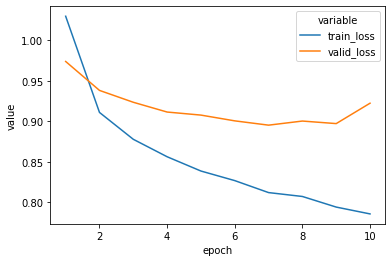

In [ ]:
plot_metrics([history])

# Inference

In [ ]:
# Encode
encoder_model = Model(encoder_input, [enc_output, enc_state_h, enc_state_c])

# Inputs for decode
dec_state_input_h = Input(shape=(hidden_dim,))
dec_state_input_c = Input(shape=(hidden_dim,))
dec_hidden_state_input = Input(shape=(encoder_maxlen, hidden_dim))

# Decode
dec_emb_out2 = dec_emb(decoder_input)
dec_output2, dec_state_h2, dec_state_c2 = dec_lstm(dec_emb_out2, initial_state=[dec_state_input_h, dec_state_input_c])
attn_out2 = attn([dec_output2, dec_hidden_state_input])
concat_out2 = concat([dec_output2, attn_out2])
output = dec_fc(concat_out2)

decoder_model = Model([decoder_input] + [dec_hidden_state_input, dec_state_input_h, dec_state_input_c], [output] + [dec_state_h2, dec_state_c2])

In [ ]:
input_index_word = dict(zip(range(len(input_vocab)), input_vocab))
output_index_word = dict(zip(range(len(output_vocab)), output_vocab))

reverse_target_word_index=output_index_word
reverse_source_word_index=input_index_word
target_word_index=output_word_index

In [ ]:
index_word = dict(zip(range(len(vocab)), vocab))

reverse_target_word_index=index_word
reverse_source_word_index=index_word
target_word_index=word_index

In [ ]:
reverse_target_word_index=tokenizers[1].index_word
reverse_source_word_index=tokenizers[0].index_word
target_word_index=tokenizers[1].word_index

In [ ]:
import numpy as np

def decode_sequence(input_seq):
  e_out, e_h, e_c = encoder_model.predict(input_seq)

  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = target_word_index[start_token]

  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:

    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

    # sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    try:
      sampled_token = reverse_target_word_index[sampled_token_index]
    except:
      sampled_token = '[UNK]'

    if(sampled_token != end_token):
      decoded_sentence += ' '+sampled_token

    # Exit condition: either hit max length or find stop word.
    if (sampled_token == end_token  or len(decoded_sentence.split()) >= (decoder_maxlen - 1)):
      stop_condition = True

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # Update internal states
    e_h, e_c = h, c

  return decoded_sentence

In [ ]:
import numpy as np

def decode_sequence2(input_seq, length):
  e_out, e_h, e_c = encoder_model.predict(input_seq)

  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = input_seq[0][0]

  decoded_sentence = reverse_source_word_index[input_seq[0][0]]
  print('first: ', decoded_sentence)
  for _ in range(length):

    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

    # sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :][1:]) + 1
    try:
      sampled_token = reverse_target_word_index[sampled_token_index]
    except:
      sampled_token = '[UNK]'

    decoded_sentence += ' ' + sampled_token

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # Update internal states
    e_h, e_c = h, c

  return decoded_sentence

In [ ]:
import numpy as np

def decode_sequence3(input_seq):
  e_out, e_h, e_c = encoder_model.predict(input_seq)

  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = target_word_index['[UNK]']

  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:

    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

    # sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    try:
      sampled_token = reverse_target_word_index[sampled_token_index]
    except:
      sampled_token = '[UNK]'

    if(sampled_token != '[UNK]'):
      decoded_sentence += ' '+sampled_token

    # Exit condition: either hit max length or find stop word.
    if (sampled_token == '[UNK]'  or len(decoded_sentence.split()) >= (decoder_maxlen - 1)):
      stop_condition = True

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # Update internal states
    e_h, e_c = h, c

  return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for item in input_seq:
        if(item != 0 and item != target_word_index[start_token] and item != target_word_index[end_token]):
          try:
            new_str = reverse_target_word_index[item]
          except:
            new_str = '[UNK]'
          newString = newString + new_str + ' '
    return newString

def seq2summary2(input_seq):
    newString=''
    for item in input_seq:
        if(item != 0):
          try:
            new_str = reverse_target_word_index[item]
          except:
            new_str = '[UNK]'
          newString = newString + new_str + ' '
    return newString

def seq2summary3(input_seq):
    newString=''
    for item in input_seq:
        if(item != 0):
          try:
            new_str = reverse_target_word_index[item]
          except:
            new_str = '[UNK]'
          newString = newString + new_str + ' '
    return newString

def seq2text(input_seq):
    newString=''
    for item in input_seq:
      if(item != 0):
        try:
          new_str = reverse_source_word_index[item]
        except:
          new_str = '[UNK]'
        newString = newString + new_str + ' '
    return newString

#### No start/end tokens

In [ ]:
for i in range(5):
    print("Text:",seq2text(X_train[i]))
    print("Original title:",seq2summary2(Y_train[i]))
    print("Predicted title:",decode_sequence2(X_train[i].reshape(1, -1), len([x for x in Y_train[i] if x != 0])))
    print("\n")

Text: i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most 
Original title: good quality dog food 
first:  i
Predicted title: i best dog food for


Text: product arrived labeled as jumbo salted [UNK] peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo 
Original title: not as advertised 
first:  product
Predicted title: product the best but


Text: this is a confection that has been around a few centuries it is a light [UNK] citrus gelatin with nuts in this case [UNK] and it is cut into tiny squares and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you are familiar with the story of cs [UNK] the lion t

#### Start/end token everything with only one tokenizer (40000 tokens, sostr/eostr not included in vocab)

In [ ]:
for i in range(10):
    i = i
    print("Text:",seq2text(X_train[i]))
    print("Original title:",seq2summary3(Y_train[i]))
    print("Predicted title:",decode_sequence3(X_train[i].reshape(1, -1)))
    print("\n")

Text: [UNK] i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most [UNK] 
Original title: [UNK] good quality dog food [UNK] 
Predicted title:  great for dogs


Text: [UNK] product arrived labeled as jumbo salted peanutsthe peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo [UNK] 
Original title: [UNK] not as advertised [UNK] 
Predicted title:  not what i expected


Text: [UNK] this is a confection that has been around a few centuries it is a light pillowy citrus gelatin with nuts in this case filberts and it is cut into tiny squares and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you are familiar wit

#### Start/end token everything with only one tokenizer (15000 tokens)

In [ ]:
for i in range(10):
    i = i
    print("Text:",seq2summary(X_train[i]))
    print("Original title:",seq2summary(Y_train[i]))
    print("Predicted title:",decode_sequence(X_train[i].reshape(1, -1)))
    print("\n")

Text: i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most 
Original title: good quality dog food 
Predicted title:  great product


Text: product arrived labeled as jumbo salted [UNK] peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo 
Original title: not as advertised 
Predicted title:  great product


Text: this is a confection that has been around a few centuries it is a light [UNK] citrus gelatin with nuts in this case [UNK] and it is cut into tiny squares and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you are familiar with the story of cs [UNK] the lion the witch and the wardrobe this is the